In [7]:
%matplotlib inline
from qpms.constants import * # π  ℏ  eV eV2nm
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
ň = None

In [2]:
# auxilliary function to make a (n+1,)-sized mesh limit array from a (n,)-sized data point array
# used mainly for making the x and y arguments for matplotlib's pcolormesh method
def make_meshnodes(datapoints):
    datapoints = np.array(datapoints)
    if len(datapoints.shape) != 1 or len(datapoints) < 2:
        raise ValueError('datapoints must be a 1-dimensional numpy array or compatible and must contain at least 2 elements')
    meshnodes = np.empty((datapoints.shape[0]+1,))
    meshnodes[0] = datapoints[0] - (datapoints[1] - datapoints[0])/2
    meshnodes[1:-1] = (datapoints[:-1] + datapoints[1:]) / 2
    meshnodes[-1] = datapoints[-1] - (datapoints[-1] - datapoints[-2])/2
    return meshnodes

# Fig. 3 (k-λ lasing data and 2D dispersion simulations)

In [45]:
nrow = 5 # number of plot rows
xrange_nm = [500, 650]
yrange_invm = None
freq_prune_interval_eV = 0.001#0.00005 # workaround for the white lines appearing with pcolormesh()
# pre-calculated dispersions / lowest singular values
dispsim2d_files = ["/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x370_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
]
# Sara's intensity data; TODO
lasingdata_files = ["/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
]
dimension_labels = ['$380\\,\\mathrm{nm}\\times 370\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 375\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 380\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 385\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 390\\mathrm{nm}$',
]

In [46]:
# load and process the simulation data
dispsim2d_plotdata = list()
for dispsimfile in dispsim2d_files:
    dispdata = np.load(dispsimfile)
    # the data are calculated only for non-negative k_y; the other side is obtained by mirror symmetry
    ks_orig = dispdata['ks']
    nfreq, nk_orig = dispdata['leastSVs'].shape
    leastSVs_half = dispdata['leastSVs']
    ks = np.empty((nk_orig*2-1))
    ks[:nk_orig] = - ks_orig[0,::-1] # negative k's
    ks[nk_orig-1:] = ks_orig[0,:] # positive k's
    freqs = dispdata['freqs'][:,0]
    
    #prune freqs, otherwise white line artifacts might appear in pcolormesh rasterized output
    freqmask = np.ones(freqs.shape, dtype=bool)
    lastone = 0
    for freqi in range(1,nfreq):
        if freqs[freqi] < freqs[lastone] + freq_prune_interval_eV*eV/ℏ:
            freqmask[freqi] = False
        else:
            lastone = freqi
    freqs = freqs[freqmask]
    leastSVs_half = leastSVs_half[freqmask]
    nfreq = len(freqs)
    
    
    #ks = ks[ň,:]
    leastSVs = np.empty((nfreq, nk_orig*2-1))
    leastSVs[:,:nk_orig] = leastSVs_half[:,::-1] # negative k's
    leastSVs[:,nk_orig-1:] = leastSVs_half[:,:] # positive k's
    
    lambdas_nm = eV2nm(freqs/(eV/ℏ))#[ň,:]
    # sort by wavelength, not energy
    #lambdas_nm = lambdas_nm[::-1]
    #leastSVs = leastSVs[::-1]
    #print(lambdas_nm.shape,dispdata['leastSVs'].shape)
    #print(lambdas_nm[0],lambdas_nm[-1])
    print(lambdas_nm.shape, ks.shape, leastSVs.shape)
    dispsim2d_plotdata.append((freqs, lambdas_nm, ks, leastSVs))
    
# TODO load and process the measurement data

(492,) (1041,) (492, 1041)
(492,) (1041,) (492, 1041)
(492,) (1041,) (492, 1041)
(492,) (1041,) (492, 1041)
(492,) (1041,) (492, 1041)


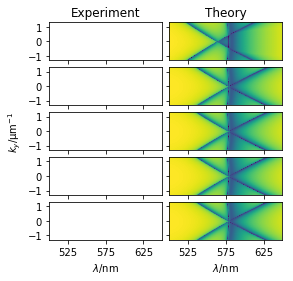

In [48]:
# the plot
f = plt.figure(1, (4., 4.))
axes = ImageGrid(#cf. https://matplotlib.org/tutorials/toolkits/axes_grid.html
                 f, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 2),  # creates 5x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=False,
                 share_all=True,
                 )
axes[0].set_title('Experiment')
axes[1].set_title('Theory')
for i in range(nrow):
    freqs, lambdas_nm, ks, leastSVs = dispsim2d_plotdata[i]
    ax = axes[2*i+1]
    ax.set_xlim(xrange_nm)
    ax.set_xticks([525,575,625,])
    ax.set_xlabel('$\\lambda/\\mathrm{nm}$')
    ax.set_yticks([-1,0,1])
    ax.set_ylabel('$k_y/\\mathrm{\\mu m^{-1}}$')
    im = ax.pcolormesh(make_meshnodes(lambdas_nm), make_meshnodes(ks)/1e6, leastSVs.T, rasterized=True)
for i in range(nrow):
    ax = axes[2*i+0]
    ax.set_xlabel('$\\lambda/\\mathrm{nm}$')
    ax.set_yticks([-1,0,1])
    if i == 2: ax.set_ylabel('$k_y/\\mathrm{\\mu m^{-1}}$')
    
f.subplots_adjust(left=0.15, right=0.96)
f.savefig("figs/test.pdf", dpi=400)
#f.savefig("figs/test.png", dpi=1200)